<a href="https://colab.research.google.com/github/Daeun-Danna-Lee/NLP_AAI3011/blob/main/%08NLTK_NER_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개체명 인식

### 1. NLTK를 이용한 개체명 인식(Named Entity Recognition using NTLK)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence = pos_tag(word_tokenize(sentence))
print(sentence) # 토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [ ]:
sentence = ne_chunk(sentence)
print(sentence) # 개체명 인식

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


## 개체명 인식의 BIO 표현 이해하기

### 1. 데이터 전처리하기

In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
f = open('./train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [ ]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14040


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [ ]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.502635


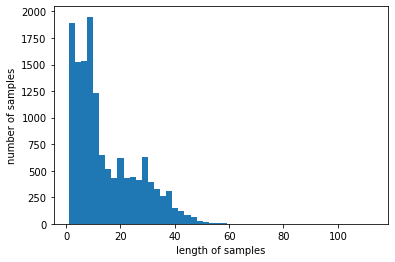

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))


단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [ ]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))


기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [ ]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2808, 70)
테스트 샘플 레이블의 크기 : (2808, 70, 10)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 22s 112ms/step - loss: 0.1902 - accuracy: 0.8247 - val_loss: 0.1303 - val_accuracy: 0.8324
Epoch 2/8
88/88 [==============================] - 6s 65ms/step - loss: 0.1022 - accuracy: 0.8524 - val_loss: 0.0798 - val_accuracy: 0.8793
Epoch 3/8
88/88 [==============================] - 5s 62ms/step - loss: 0.0673 - accuracy: 0.9020 - val_loss: 0.0575 - val_accuracy: 0.9171
Epoch 4/8
88/88 [==============================] - 5s 62ms/step - loss: 0.0480 - accuracy: 0.9321 - val_loss: 0.0434 - val_accuracy: 0.9402
Epoch 5/8
88/88 [==============================] - 5s 61ms/step - loss: 0.0363 - accuracy: 0.9491 - val_loss: 0.0373 - val_accuracy: 0.9494
Epoch 6/8
88/88 [==============================] - 5s 61ms/step - loss: 0.0293 - accuracy: 0.9586 - val_loss: 0.0354 - val_accuracy: 0.9530
Epoch 7/8
88/88 [==============================] - 5s 60ms/step - loss: 0.0253 - accuracy: 0.9637 - val_loss: 0.0329 - val_accuracy: 0.9549
Epoch 8/8
88/88 [=

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 2s 18ms/step - loss: 0.0338 - accuracy: 0.9571

 테스트 정확도: 0.9571


In [ ]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre

## BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

### 1. 개체명 인식 데이터에 대한 이해와 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv("./ner_dataset.csv", encoding="latin1")

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


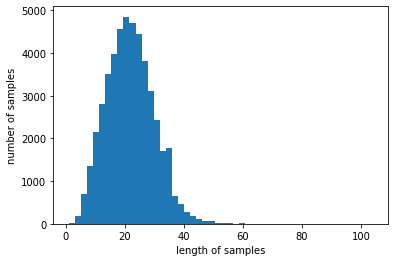

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


### 2. 양방향 LSTM을 이용한 개체명 인식

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation=('softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 31s 76ms/step - loss: 0.1764 - accuracy: 0.8749 - val_loss: 0.0792 - val_accuracy: 0.9301
Epoch 2/6
270/270 [==============================] - 17s 62ms/step - loss: 0.0542 - accuracy: 0.9502 - val_loss: 0.0484 - val_accuracy: 0.9550
Epoch 3/6
270/270 [==============================] - 17s 62ms/step - loss: 0.0371 - accuracy: 0.9646 - val_loss: 0.0445 - val_accuracy: 0.9571
Epoch 4/6
270/270 [==============================] - 17s 62ms/step - loss: 0.0299 - accuracy: 0.9704 - val_loss: 0.0431 - val_accuracy: 0.9591
Epoch 5/6
270/270 [==============================] - 17s 61ms/step - loss: 0.0258 - accuracy: 0.9739 - val_loss: 0.0437 - val_accuracy: 0.9594
Epoch 6/6
270/270 [==============================] - 17s 61ms/step - loss: 0.0225 - accuracy: 0.9770 - val_loss: 0.0444 - val_accuracy: 0.9590


In [ ]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


### 3. F1-Score

In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true) #실제값의 길이만큼 전부 'O'로 채워진 리스트 생성. 예측값으로 사용.
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
hit = 0 # 정답 개수
for t, p in zip(true, predicted):
    if t == p:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(true) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=294daad1eb2f3741eecc32994c8eb4fa1ac7e8a35016e4150c53a09941c7594c
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



### 4. F1-score로 성능 측정하기

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        word_sequence = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(word_sequence)
    return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.42      0.27      0.33        52
         geo       0.81      0.86      0.84      7620
         gpe       0.95      0.95      0.95      3145
         nat       0.60      0.16      0.26        37
         org       0.61      0.55      0.58      4033
         per       0.73      0.70      0.71      3545
         tim       0.86      0.84      0.85      4067

   micro avg       0.79      0.78      0.79     22562
   macro avg       0.62      0.54      0.56     22562
weighted avg       0.79      0.78      0.78     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 78.9%
